<a href="https://colab.research.google.com/github/filiperobotic/cursoDL/blob/master/codes/aula6/medical_marijuana_answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!git clone https://github.com/filiperobotic/cursoDL.git

Cloning into 'cursoDL'...
remote: Enumerating objects: 3603, done.
remote: Counting objects: 100% (3603/3603), done.
remote: Compressing objects: 100% (2811/2811), done.
remote: Total 6863 (delta 801), reused 3581 (delta 791), pack-reused 3260
Receiving objects: 100% (6863/6863), 418.66 MiB | 14.53 MiB/s, done.
Resolving deltas: 100% (879/879), done.
Checking out files: 100% (6593/6593), done.


In [0]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

Using TensorFlow backend.


In [0]:
def build(width, height, depth, classes, reg):
		# initialize the model along with the input shape to be
		# "channels last"
		model = Sequential()
		inputShape = (height, width, depth)
 
		# if we are using "channels first", update the input shape
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
      
    # first set of CONV => RELU => POOL layers
		model.add(Conv2D(64, (11, 11), input_shape=inputShape,
			padding="same", kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
 
		# second set of CONV => RELU => POOL layers
		model.add(Conv2D(128, (5, 5), padding="same",
			kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
 
		# third (and final) CONV => RELU => POOL layers
		model.add(Conv2D(256, (3, 3), padding="same",
			kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
    
    # first and only set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(512, kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(Dropout(0.5))
 
		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))
 
		# return the constructed network architecture
		return model



In [0]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
 
# import the necessary packages
#from pyimagesearch.simplenet import SimpleNet
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils
from imutils import build_montages
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

# construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-d", "--dataset", required=True,
# 	help="path to input dataset")
# ap.add_argument("-e", "--epochs", type=int, default=100,
# 	help="# of epochs to train our network for")
# ap.add_argument("-p", "--plot", type=str, default="plot.png",
# 	help="path to output loss/accuracy plot")
# args = vars(ap.parse_args())

arg_dataset = "cursoDL/imagens/datasets/medical-marijuana"
arg_epochs = 100



# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(arg_dataset))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the image, convert it to grayscale, and resize it to be a
	# fixed 64x64 pixels, ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	image = cv2.resize(image, (64, 64))

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data into a NumPy array, then preprocess it by scaling
# all pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0

# reshape the data matrix so that it explicity includes a channel
# dimension
data = data.reshape((data.shape[0], data.shape[1], data.shape[2], 1))

# encode the labels (which are currently strings) as integers
le = LabelEncoder()
labels = le.fit_transform(labels)

# transform the labels into vectors in the range [0, classes],
# generating a vector for each label, where the index of the label
# is set to '1' and all other entries are set to '0' -- this process
# is called "one-hot encoding"
labels = np_utils.to_categorical(labels, 2)

# partition the data into training and testing splits using 60% of
# the data for training and the remaining 40% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.40, stratify=labels, random_state=42)

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = Adam(lr=1e-4, decay=1e-4 / arg_epochs)
model = build(width=64, height=64, depth=1,
	classes=len(le.classes_), reg=l2(0.0002))
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the network
print("[INFO] training network for {} epochs...".format(
	arg_epochs))
H = model.fit(trainX, trainY, validation_data=(testX, testY),
	batch_size=32, epochs=arg_epochs, verbose=1)

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=le.classes_))



[INFO] loading images...
[INFO] compiling model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
[INFO] training network for 100 epochs...
Instructions for updating:
Use tf.cast instead.
Train on 914 samples, validate on 610 samples
Epoch 1/100
914/914 [==============================] - 8s 9ms/step - loss: 0.9554 - acc: 0.4934 - val_loss: 0.9275 - val_acc: 0.5098
Epoch 2/100
914/914 [==============================] - 2s 2ms/step - loss: 0.9247 - acc: 0.4781 - val_loss: 0.9107 - val_acc: 0.5098
Epoch 3/100
914/914 [==============================] - 2s 2ms/step - loss: 0.9035 - acc: 0.5263 - val_loss: 0.8952 - val_acc: 0.5082
Epoch 4/100
914/914 [==============================] - 2s 2ms/step - loss: 0.8879 - acc: 0.5525 - val_loss: 0.8804 - val_acc: 0.5098
Epoch 5/100
914/914 [==============================] - 2s 2ms/step - loss: 0.8712 - acc: 0.550

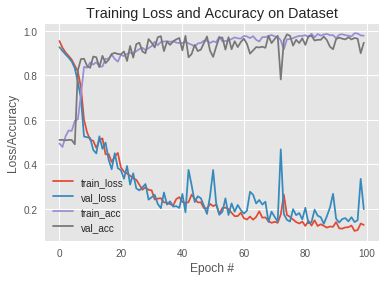

In [0]:
%matplotlib inline  

# plot the training loss and accuracy
N = arg_epochs

plt.figure()
plt.style.use("ggplot")
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
#plt.savefig(args["plot"])



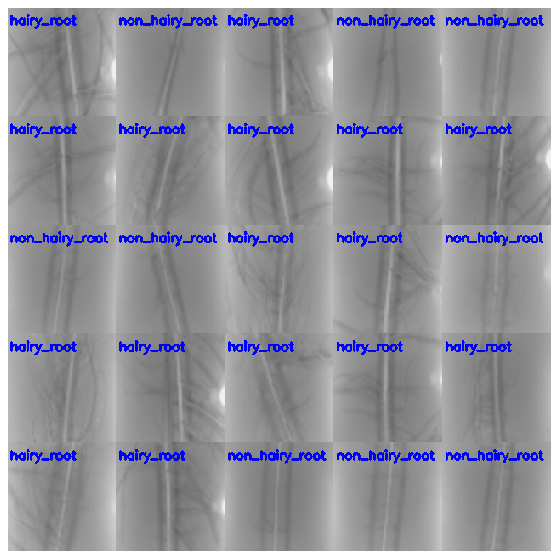

In [0]:
# randomly select a few testing images and then initialize the output
# set of images
idxs = np.arange(0, testY.shape[0])
idxs = np.random.choice(idxs, size=(25,), replace=False)
images = []

# loop over the testing indexes
for i in idxs:
	# grab the current testing image and classify it
	image = np.expand_dims(testX[i], axis=0)
	preds = model.predict(image)
	j = preds.argmax(axis=1)[0]
	label = le.classes_[j]

	# rescale the image into the range [0, 255] and then resize it so
	# we can more easily visualize it
	output = (image[0] * 255).astype("uint8")
	output = np.dstack([output] * 3)
	output = cv2.resize(output, (128, 128))

	# draw the class label on the output image and add it to the set
	# of output images
	cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
		(0, 0, 255), 2)
	images.append(output)

# create a montage using 128x128 "tiles" with 5 rows and 5 columns
montage = build_montages(images, (128, 128), (5, 5))[0]

# show the output montage

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1, xticks=[], yticks=[])
ax.imshow(montage)
#cv2.imshow("Output", montage)
#cv2.waitKey(0)